# üì∏Shallow Focus With Computation
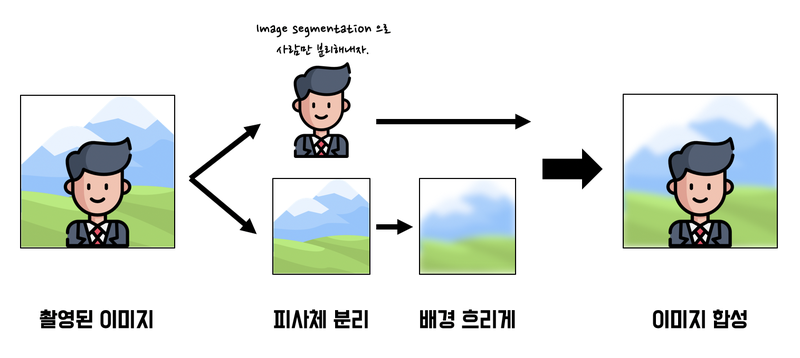
<div style="text-align: right"> Ï∂úÏ≤ò: LMS EXP 8</div>

- ÌùîÌûà ÏïÑÏõÉÌè¨Ïª§Ïä§Î•º ÏúÑÌï¥ DSLRÏùÑ Íµ¨Îß§ÌïòÎçò ÎÇ†Îì§Ïù¥ ÏûàÏùÑ Í≤ÉÏù¥Îã§. Ïù¥Î≤à Í≥ºÏ†úÏóêÏÑúÎäî `ÎàÑÎÅºÎî∞Í∏∞`ÏôÄ `ÏïÑÏõÉÌè¨Ïª§Ïã±`ÏùÑ DeepLabV3+ Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìï¥ ÏßÑÌñâÌï¥ Î≥º Í≤ÉÏù¥Îã§.
- ÎòêÌïú Ïù¥ Í≥ºÏ†ïÏóêÏÑú Î∞úÏÉùÌïòÎäî ÏûëÏùÄ Ïò§Î•òÎ•º Í∞úÏÑ†Ìï† Ïàò ÏûàÎäî Î∞©Î≤ïÏúºÎ°ú Google BrainÏóê Í∏∞Ïû¨Îêú `struct2depth`Í∏∞Î≤ïÏùÑ ÏÇ¥Ìé¥Î≥¥Í≥†Ïûê ÌïúÎã§.

Î™©Ï∞®
1. [MODEL Ï†ÅÏö©](#1.-MODEL-Ï†ÅÏö©)
2. [Î∞∞Í≤Ω Ï§ÄÎπÑ](#2.-Î∞∞Í≤ΩÏ§ÄÎπÑ)
3. [Ìï©ÏÑ±](#3.-Ìï©ÏÑ±)
4. [[Part2] Î¨∏Ï†úÏ†ê ÏãùÎ≥Ñ](#[Part2]-Î¨∏Ï†úÏ†ê-ÏãùÎ≥Ñ)
5. [[Part3] Î¨∏Ï†ú Ìï¥Í≤∞ÏùÑ ÏúÑÌïú Ï†úÏñ∏](#[Part3]-Î¨∏Ï†úÏ†ê-Ìï¥Í≤∞)

In [18]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

import os

# 1. MODEL Ï†ÅÏö©

## 1-1. Model Î∂àÎü¨Ïò§Í∏∞

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()ÏóêÏÑú Î™®Îç∏ Íµ¨Ï°∞Î•º ÏßÅÏ†ë Íµ¨ÌòÑÌïòÎäî ÎåÄÏã†, tar fileÏóêÏÑú ÏùΩÏñ¥Îì§Ïù∏ Í∑∏ÎûòÌîÑÍµ¨Ï°∞ graph_defÎ•º 
    # tf.compat.v1.import_graph_defÎ•º ÌÜµÌï¥ Î∂àÎü¨Îì§Ïó¨ ÌôúÏö©ÌïòÍ≤å Îê©ÎãàÎã§. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # Ïù¥ÎØ∏ÏßÄÎ•º Ï†ÑÏ≤òÎ¶¨ÌïòÏó¨ Tensorflow ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö© Í∞ÄÎä•Ìïú shapeÏùò Numpy ArrayÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1ÏóêÏÑúÎäî model(input) Î∞©ÏãùÏù¥ ÏïÑÎãàÎùº sess.run(feed_dict={input...}) Î∞©ÏãùÏùÑ ÌôúÏö©Ìï©ÎãàÎã§.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 1-2. Model Ï†ÅÏö©Ìï¥ÏÑú Segmentation ÌôïÎ≥¥ÌïòÍ∏∞
- ÎÇòÏùò ÏÇ¨ÏßÑÍ≥º Í≥†ÏñëÏù¥ ÏÇ¨ÏßÑ Î∂àÎü¨Ïò§Í∏∞

In [66]:
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
addr_dict = {'me.jpg' : 'person', 'cat.png' : 'cat'}

img_paths = []
for img in addr_dict.keys():
    img_paths.append(os.path.join(img_dir, img))
    
img_origs = []
for img_path in img_paths :
    img_origs.append(cv2.imread(img_path))
    print(img_origs[-1].shape)

(633, 475, 3)
(394, 596, 3)


- Î∞∞Í≤ΩÌï©ÏÑ±ÏùÑ ÏúÑÌï¥ Î∞∞Í≤ΩÏÇ¨ÏßÑÏùÑ Î∂àÎü¨Ïò§Í≥† ÎÇòÏùò ÏÇ¨ÏßÑ resizeÌïòÍ∏∞

In [67]:
img_path = os.path.join(img_dir, 'gameofthrone.jpg')
back_ground = cv2.imread(img_path)

In [67]:
img_orig = img_origs[0]
img_orig_resized = cv2.resize(img_orig, (int( (img_orig.shape[1]/img_orig.shape[0]) * back_ground.shape[0] ), back_ground.shape[0] ) )
img_origs.append(img_orig_resized)

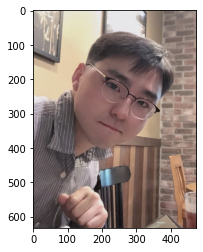

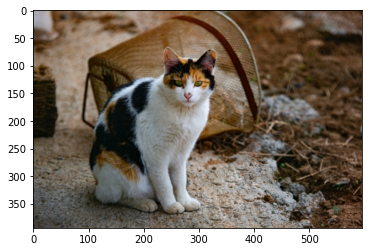

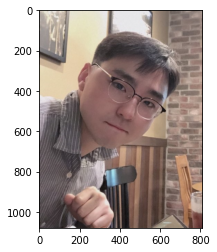

In [75]:
for img_orig in img_origs :
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

- Î™®Îç∏ Ï†ÅÏö©ÌïòÍ∏∞

In [68]:
img_segs = []
for img_orig in img_origs :
    img_segs.append(MODEL.run(img_orig))
#     img_resized, seg_map = MODEL.run(img_orig)
#     print (img_orig.shape, img_resized.shape, seg_map.max())
    print(img_orig.shape, img_segs[-1][0].shape, img_segs[-1][1].max())

(633, 475, 3) (513, 384, 3) 15
(394, 596, 3) (339, 513, 3) 8
(1080, 810, 3) (513, 384, 3) 15


In [5]:
# LABEL_NAMES = [
#     'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#     'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
#     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
# ]
# len(LABEL_NAMES)

21

- MODELÍ≤∞Í≥ºÍ∞í(resized image, segment map) Ìï¥ÏÑù
  - seg_mapÏùÄ Í≤ÄÏ∂úÎêú ÌîΩÏÖÄÏùò classÎ•º ÏùòÎØ∏ÌïúÎã§

- sement mapÏùÑ ÌôúÏö©ÌïòÍ∏∞ ÏúÑÌï¥ mask ÎßåÎì§Í∏∞
  - applyColorMap() Ìï®ÏàòÎ°ú ÏÉâÏùÑ Ï†ÅÏö©

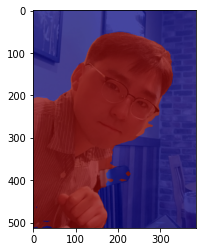

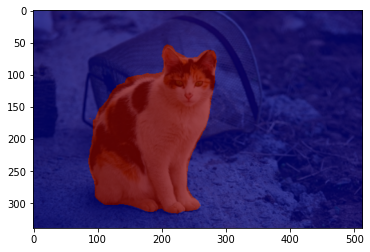

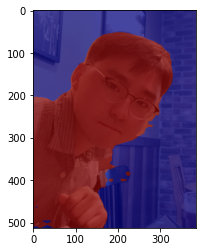

In [70]:
img_shows = []
for img_seg in img_segs :
    img_resized = img_seg[0]
    img_shows.append(img_resized.copy())

#sementic segmentationÏùÑ Ï†ÅÏö©Ìïú ÌõÑ maskÎ•º ÎßåÎì†Îã§
seg_maps = []
for img_seg, img_class in zip(img_segs,['person', 'cat', 'person']) :
    seg_map = img_seg[1]
    if img_class == 'person':
        seg_maps.append(np.where(seg_map == 15, 15, 0))
    elif img_class == 'cat':
        seg_maps.append(np.where(seg_map == 8, 8, 0))

img_masks = []
color_masks = []
for seg_map in seg_maps :
    img_mask = (seg_map * (255/seg_map.max())).astype(np.uint8)
    img_masks.append(img_mask)
    color_masks.append(cv2.applyColorMap(img_mask, cv2.COLORMAP_JET))

#maskÎ•º Ïù¥Ïö©ÌïòÏó¨ Ïù¥ÎØ∏ÏßÄÎ•º Ï∂úÎ†•ÌïúÎã§ 
for idx, img_mask in enumerate(zip(img_shows, color_masks)) :
    img_show, color_mask = img_mask
    img_shows[idx] = cv2.addWeighted(img_show, 0.3, color_mask, 0.7, 0.0)

for img_show in img_shows :
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

# img_show = img_resized.copy()
# seg_map = np.where(seg_map == 15, 15, 0) # ÏòàÏ∏° Ï§ë ÏÇ¨ÎûåÎßå Ï∂îÏ∂ú

# img_mask = seg_map * (255/seg_map.max()) # 255 normalization
# img_mask = img_mask.astype(np.uint8)
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

- ÏÑ∏Í∑∏Î®ºÌÖåÏù¥ÏÖò Í≤∞Í≥ºÎ•º ÏõêÎûò ÌÅ¨Í∏∞Î°ú Î≥µÏõêÌïòÍ∏∞
    - Î≥¥Í∞Ñinterpolation: Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î•º Î≥ÄÍ≤Ω(scaling)ÌïòÎäî Í≥ºÏ†ïÏóêÏÑú Ïª¥Ìì®ÌÑ∞Í∞Ä ÏÇ¨Ïù¥ÏÇ¨Ïù¥ ÌîΩÏÖÄÍ∞íÏùÑ Ï±ÑÏö∞Îäî Î∞©Î≤ï [Ï∞∏Í≥†ÏûêÎ£å](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html)
    - cv2.INTER_NEAREST Í∞ÄÎä• / cv2.INTER_LINEAR Ï†ïÌôï

Í≤∞Í≥ºÏ†ÅÏúºÎ°ú img_mask_up ÏùÄ Í≤ΩÍ≥ÑÍ∞Ä Î∏îÎü¨Îêú ÌîΩÏÖÄÍ∞í 0~255Ïùò Ïù¥ÎØ∏ÏßÄÎ•º ÏñªÏäµÎãàÎã§. ÌôïÏã§Ìïú Í≤ΩÍ≥ÑÎ•º Îã§Ïãú Ï†ïÌïòÍ∏∞ ÏúÑÌï¥ Ï§ëÍ∞ÑÍ∞íÏù∏ 128ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏûÑÍ≥ÑÍ∞í(threshold)ÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§. 128 Ïù¥ÌïòÏùò Í∞íÏùÄ 0ÏúºÎ°ú 128 Ïù¥ÏÉÅÏùò Í∞íÏùÄ 255Î°ú ÎßåÎìúÎäî Î∞©Î≤ïÏûÖÎãàÎã§.

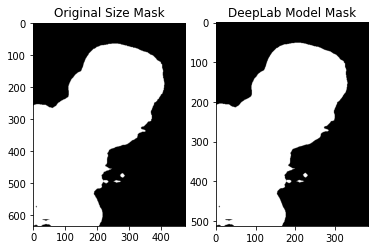

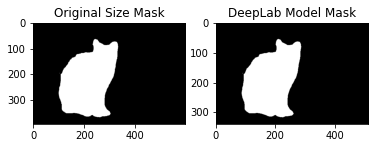

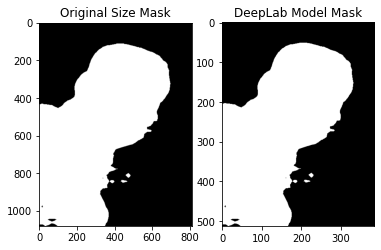

In [71]:
img_mask_ups = []
for i in range(len(img_origs)):
    img_mask_up = cv2.resize(img_masks[i], img_origs[i].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    img_mask_ups.append(img_mask_up)
    
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_masks[i], cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

# 2. Î∞∞Í≤ΩÏ§ÄÎπÑ

## 2-1. Î∞∞Í≤Ω ÌùêÎ¶¨Í≤å ÌïòÍ∏∞

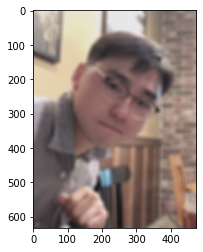

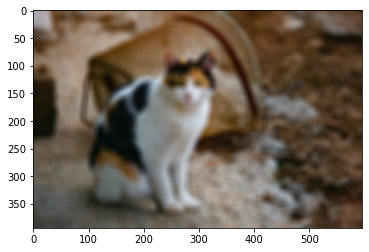

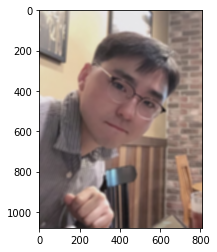

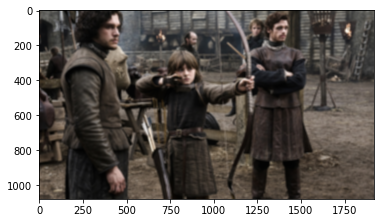

In [72]:
#Í∏∞Î≥∏ Î∞∞Í≤Ω
img_orig_blurs = []
for img_orig in img_origs:
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)ÏùÄ blurring  kernel sizeÎ•º ÎúªÌï©ÎãàÎã§. 
    img_orig_blurs.append(img_orig_blur)
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

#Ìï©ÏÑ±Ïö© Î∞∞Í≤Ω
img_background_blur = cv2.blur(back_ground, (13, 13))
plt.imshow(cv2.cvtColor(img_background_blur, cv2.COLOR_BGR2RGB))
plt.show()

- [bitwise_not, bitwise_and Í≥º Ïù¥ÎØ∏ÏßÄ](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)


## 2-2. ÌùêÎ†§ÏßÑ Î∞∞Í≤ΩÍ≥º 1ÏóêÏÑú Íµ¨Ìïú mask Ìï©ÏπòÍ∏∞

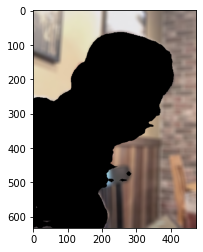

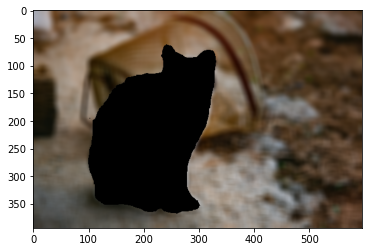

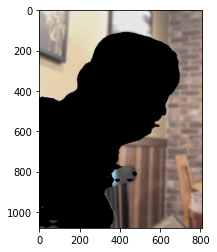

In [76]:
#ÌïÑÏöî: img_mask_up, img_orig_blur
img_mask_colors = []
img_bg_blurs = []
for i in range(len(img_mask_ups)):
    img_mask_color = cv2.cvtColor(img_mask_ups[i], cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blurs[i], img_bg_mask)
    img_mask_colors.append(img_mask_color)
    img_bg_blurs.append(img_bg_blur)
    plt.imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

# 3. Ìï©ÏÑ± 
- [np.where( )](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

### Î∞∞Í≤ΩÏùÑ ÌùêÎ¶¨Í≤å Ï≤òÎ¶¨Ìï¥Î≥¥Ïûê!
#### [‚ë† Ïù∏Î¨ºÏÇ¨ÏßÑÍ≥º ‚ë°Í≥†ÏñëÏù¥ ÏÇ¨ÏßÑ]

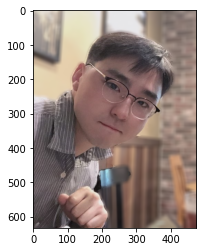

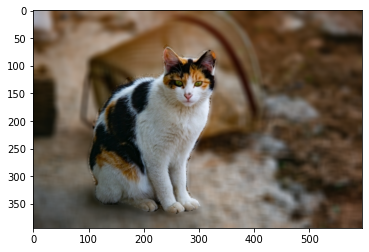

In [88]:
for i in range(len(img_origs[:-1])):
    img_concat = np.where(img_mask_colors[i]==255, img_origs[i], img_bg_blurs[i])
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    cv2.imwrite(os.path.join(img_dir,f'blurred_img_{i}.jpg'),img_concat)

### ÏôïÏ¢åÏùò Í≤åÏûÑ ÏÜç Ìïú Ïû•Î©¥Ïóê Îì§Ïñ¥Í∞ÄÎ≥¥Ïûê!
#### [‚ë¢ Î∞∞Í≤ΩÏ†ÑÌôò ÌÅ¨Î°úÎßàÌÇ§]

In [85]:
target_area = img_background_blur[:,:810,:]
img_background_blur[:, :810, :] = np.where(img_mask_colors[-1]==255, img_origs[-1], target_area)

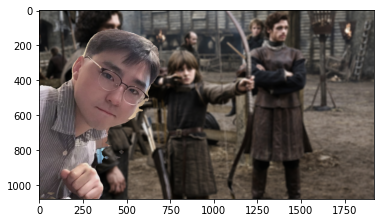

In [86]:
plt.imshow(cv2.cvtColor(img_background_blur, cv2.COLOR_BGR2RGB))
plt.show()

## [Part2] Î¨∏Ï†úÏ†ê ÏãùÎ≥Ñ

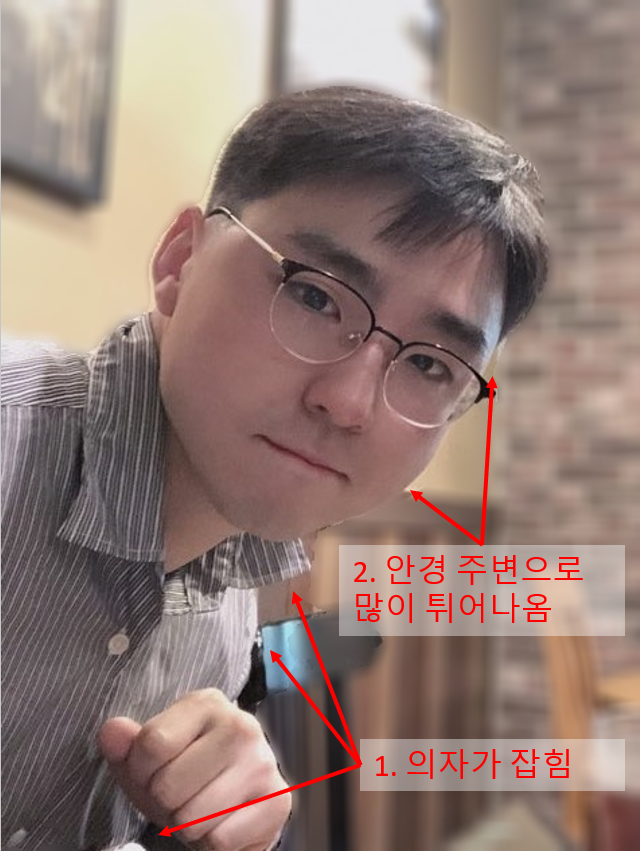

## [Part3] Î¨∏Ï†úÏ†ê Ìï¥Í≤∞
- SegmentationÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú RGBÍ∞íÏùÑ Î∞õÏïÑ Ïã¨ÎèÑÎ•º Ï∂îÏ†ïÌïòÎäî ÏûëÏóÖÏúºÎ°ú, ÏûêÏó∞Ï†ÅÏù∏ ÌïúÍ≥ÑÎ•º ÏßÄÎãåÎã§. Í∑∏Î†áÎã§Î©¥ Ïñ¥ÎñªÍ≤å Ïù¥Îü¨Ìïú Ï∂îÏ†ïÏùÑ Îçî Ï†ïÌôïÌïòÍ≤å ÎßåÎì§ Ïàò ÏûàÏùÑÍπå ? ÎÖ∏ÎìúÏóêÏÑú Ï†úÏïàÌïú Ïó¨Îü¨Í∞ÄÏßÄ Î∞©Î≤ïÏ§ë **[struct2depth](https://sites.google.com/view/struct2depth)**Î•º ÏÇ¥Ìé¥Î≥¥Í∏∞Î°ú ÌïúÎã§. [Ï∞∏Í≥†: ÏΩîÎìú](https://github.com/tensorflow/models/tree/archive/research/struct2depth)
- Í¥ÄÎ†®Ïö©Ïñ¥
  - ego-motion : ÌôòÍ≤Ω ÎÇ¥ÏóêÏÑú Ïπ¥Î©îÎùºÏùò 3Ï∞®Ïõê Ïù¥Îèô


 - Google BrainÏóê Í∏∞Ïû¨Îêú Unsupervised Learning of Depth and Ego-Motion: A Structured ApproachÎÖºÎ¨∏ÏùÄ ÌïòÎÇòÏùò Ïπ¥Î©îÎùºÎ•º Ïù¥Ïö©Ìï¥ DynamicÌôòÍ≤ΩÏóêÏÑú Depth SensingÍ≥º Ego-MotionÏùÑ Ï∂îÏ†ïÌïòÎäî Í∏∞Î≤ïÏóê ÎåÄÌïú ÏÉàÎ°úÏö¥ Î∞©Î≤ïÏùÑ Îã§Î£®Í≥† ÏûàÎã§.
 
 - Ìï¥Îãπ ÎÖºÎ¨∏ÏóêÏÑú DepthÎ•º Ï∂îÏ†ïÌïòÍ∏∞ ÏúÑÌï¥ÏÑú depth functionÏùÑ ÎèÑÏûÖÌïòÍ≥† ÏûàÎã§.
   - $\theta : R^{HxWx3} ‚Üí R^{HxW}$: fully convolutional encoder-decoder neural network
   - $D_i = \theta(I_i)$: Ïù¥ Ìï®ÏàòÎäî Ïù¥ÎØ∏ÏßÄÎ•º ÏûÖÎ†•ÌïòÎ©¥ Depth MapÏùÑ Ï∂úÎ†•ÌïòÎäî Î∞©ÏãùÏúºÎ°ú ÏûëÎèôÌïúÎã§ 

- Ïã§Ï†úÎ°ú Ï†ÅÏö© Í≤∞Í≥º DynamicÌïú ÌôòÍ≤ΩÏóêÏÑúÎèÑ DepthÎ•º ground truthÏôÄ Í±∞Ïùò Ï∞®Ïù¥ÏóÜÏù¥ Ï∂îÏ†ïÌïòÍ≥† ÏûàÏùåÏùÑ Î≥º Ïàò ÏûàÎã§!
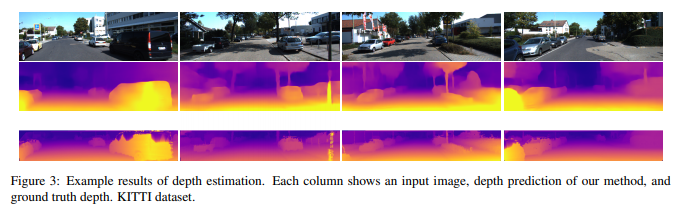
- Ïù¥Ï†ÑÏùò Ïó¨ÌÉÄ Î™®Îç∏Îì§Î≥¥Îã§ ÎÇÆÏùÄ Ïò§Ï∞®Î•º Î≥¥Ïù¥Îäî Í≤ÉÎèÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎã§.
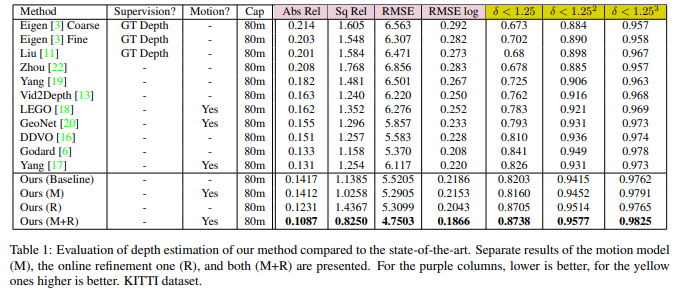

Ïù¥Ï≤òÎüº struct2depthÏóêÏÑú Ï†úÍ≥µÌïòÎäî Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÎ©¥ Ï£ºÏñ¥ÏßÑ RGBÍ∞íÏóêÏÑú DepthÎ•º Ï†ÅÏ†àÌûà Ï∂úÎ†•ÌïòÎäî Í≤ÉÏù¥ Í∞ÄÎä•ÌïòÍ≥†, Í∑∏Î†áÎã§Î©¥ Ïñ¥Î†µÏßÄ ÏïäÍ≤å shallow focusÎ•º Íµ¨ÌòÑÌï† Ïàò ÏûàÏùÑ Í≤ÉÏúºÎ°ú Í∏∞ÎåÄÎêúÎã§.

# ÌöåÍ≥†
- cvÏôÄ ÏÉàÎ°úÏö¥ ÎÖºÎ¨∏ÏùÄ Ïñ∏Ï†úÎÇò Ïñ¥Î†§Ïö¥ Ï£ºÏ†úÏù¥Îã§.
- ÎÖºÎ¨∏ÏùÑ ÏùΩÍ≥† Íµ¨ÌòÑÌï† Ïàò ÏûàÎã§Î©¥ Ï£ºÏñ¥ÏßÑ Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÎäî Í∏∞ÏÅ®ÏùÑ ÎßûÎ≥º Ïàò ÏûàÏóàÏùÑ Í≤ÉÏù¥ÏßÄÎßå, ÏïÑÏßÅ Í∑∏ Ï†ïÎèÑÏùò Ïã§Î†•Ïóê Ïù¥Î•¥ÏßÄÎäî Î™ªÌïòÏòÄÎã§.
- Ïù¥Ï†ú Ï†êÏ†ê Î≥¥Ìé∏Ï†ÅÏù∏ ÏÇ¨Í≥†Î°ú Ïì∏ Ïàò ÏûàÎäî ÏΩîÎìúÎ•º ÎÑòÏñ¥ÏÑúÎäî ÎÖ∏ÎìúÎì§Ïù¥ ÎßéÎã§Îäî ÏÉùÍ∞ÅÏù¥ Îì†Îã§. Î∞òÎ©¥Ïóê ÌòÑÏû•ÏóêÏÑúÎäî Ïù¥ÏôÄ Í∞ôÏù¥ APIÎÇò ÏÉàÎ°úÏö¥ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÎäî ÏùºÏù¥ ÎßéÏùÑ Í≤ÉÏù¥ÎØÄÎ°ú, ÏΩîÎìúÏùò Î™®Îì† Î©¥Î©¥ÏùÑ Ïù¥Ìï¥ÌïòÍ≥† Ïì∞Îäî Í≤ÉÎèÑ Ï§ëÏöîÌïòÏßÄÎßå, ÏÉàÎ°úÏö¥ ÏΩîÎìúÎ•º Ï†ÅÏ†àÌûà ÌôúÏö©ÌïòÎäî Îä•Î†•ÎèÑ Ï§ëÏöîÌïòÎã§Í≥† ÎäêÍºàÎã§.
- Î£®Î∏åÎ¶≠ ÏßÄÌëúÏùò Îëê Í∞ÄÏßÄ Í≥ºÏ†úÎäî Îã®ÏàúÌûà ÏΩîÎìúÎ•º Îî∞Îùº Ïì∞Îäî Í≤ÉÏúºÎ°ú Îã¨ÏÑ±Ìï† Ïàò ÏûàÏóàÏúºÎÇò, Íµ¨Ï≤¥Ï†ÅÏúºÎ°ú ÏΩîÎìú ÎÇ¥Î∂Ä Ìï®ÏàòÎì§Ïù¥ Ïñ¥ÎñªÍ≤å ÎèôÏûëÌïòÎäîÏßÄ Ïù¥Ìï¥ÌïòÎäîÎç∞ Î™®Îëê Ïù¥Ìï¥ÌïòÏßÄÎäî Î™ªÌñàÎã§. ÏïÑÏâΩÏßÄÎßå ÏÑ†ÌÉùÏù¥ ÌïÑÏöîÌïú Î∂ÄÎ∂ÑÏù¥ÎùºÎäî ÏÉùÍ∞ÅÏù¥ Îì†Îã§.
- Î£®Î∏åÎ¶≠ ÏßÄÌëúÏùò ÏÑ∏Î≤àÏß∏ Í≥ºÏ†úÎäî Ï£ºÏñ¥ÏßÑ Î∞©ÏãùÎì§ Ï§ë ÌïòÎÇòÎ•º ÏÑ†ÌÉùÌï¥ Ï†ÅÏö©ÌïòÎäî Í≤ÉÏù¥ÏóàÎäîÎç∞, ÌÅ∞ ÌãÄÏóê ÏûàÏñ¥ Ïù¥Ìï¥ÌïòÎ†§Í≥† ÎÖ∏Î†•ÌïòÏòÄÍ≥†, Í∏∞ÌöåÍ∞Ä ÎêúÎã§Î©¥ pytorchÎ•º Ïù¥Ïö©Ìï¥ Íµ¨ÌòÑÌï† Ïàò ÏûàÎäî Ïã§Î†•ÏùÑ Í∏∏Îü¨Î≥¥Í≥† Ïã∂Îã§Îäî ÎßàÏùåÏù¥ Îì§ÏóàÎã§.